In [1]:
from collections import defaultdict
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from abc import ABC,ABCMeta, abstractmethod

TradSeq=((1,1),(2,2),(3,3),(2,3),(1,3),(1,2))
AbaqusSeq=((1,1),(2,2),(3,3),(1,2),(1,3),(2,3))

class Material(metaclass=ABCMeta):
    @property
    @abstractmethod
    def props(self):
        pass
    
    def compliance(self):
        El,Et,Ez,nutz,nulz,nult,Gtz,Glz,Glt=self.props
        S=np.array([1/El,-nult/El,-nulz/El,0,0,0,
                       -nult/El,1/Et,-nutz/Et,0,0,0,
                       -nulz/El,-nutz/Et,1/Ez,0,0,0,
                       0,0,0,1/Gtz,0,0,
                       0,0,0,0,1/Glz,0,
                       0,0,0,0,0,1/Glt]).reshape((6,6))
        return S

    def stiffness(self):
        return np.linalg.inv(self.compliance())
    
    def planeStrainCompliance(self):
        return np.linalg.inv(self.planeStrainStiffness())
    
    def planeStrainStiffness(self):
        return self.stiffness()[np.ix_([0,1,5],[0,1,5])]
    
    def planeStressCompliance(self):
        return np.linalg.inv(self.planeStressStiffness())
    
    def planeStressStiffness(self):
        return self.compliance()[np.ix_([0,1,5],[0,1,5])]
    
    def transformCompliance(self):
        pass
    
    def transformers(theta=None,axis=None,rotate=None):
        """
        根据绕着axis轴转角为theta 或者 rotate 给定 柔度矩阵的 变换
        theta 为弧度制
        axis is [None,'x','y','z']
        rotate 的每一行都是 新坐标系下轴在旧坐标系下的向量

        transformers(theta=np.pi/2,axis='x')
        transformers(rotate=np.array([[1,0,0],[0,1,0],[0,0,1]]))
        """
        route=np.diag([1,1,1,2,2,2,])
        route_inv=np.diag([1,1,1,0.5,0.5,0.5,])
        axis_d={'x':0,'y':1,'z':2}
        if not (theta is None or axis is None):
            c,s=np.cos(theta),np.sin(theta)
            rotate=np.zeros((3,3))
            if axis not in axis_d:
                raise ValueError("axis must be in ['x','y','z']")
            k=axis_d[axis]
            rotate[k,k]=1
            i,j=(k+1)%3,(k+2)%3
            rotate[i,i]=c
            rotate[i,j]=s
            rotate[j,j]=c
            rotate[j,i]=-s
        elif rotate is None :
            raise ValueError('pleast give at least theta and axis or rotate')
        Tsgm=np.zeros((6,6))
        trad_seq=((1,1),(2,2),(3,3),(2,3),(1,3),(1,2))
        for n1 in range(6):
            i,j=trad_seq[n1][0]-1,trad_seq[n1][1]-1
            for n2 in range(6):
                k,l=trad_seq[n2][0]-1,trad_seq[n2][1]-1
                Tsgm[n1,n2]=(rotate[i,k]*rotate[j,l]+rotate[i,l]*rotate[j,k])/2 #if k==l else rotate[i,k]*rotate[j,l]+rotate[i,l]*rotate[j,k]

        Tepl=route.dot(Tsgm)
        Tsgm=Tsgm.dot(route)
        return Tepl,Tsgm

    def transform_Compliance(S,theta,axis):
        Tepl,Tsgm=transformers(theta=theta,axis=axis)
        return Tepl.dot(S).dot(Tepl.T)

    def __getattr__(self,key):
        d={ "E11":0,"E22":1,"E33":2,
            "nu23":3,"nu13":4,"nu12":5,
            "G23":6,"G13":7,"G12":8,}
        if key in d:
            return self.props[d[key]]
        else:
            raise KeyError("Not Proper key : %s"%key)
    
class IsoMaterial(Material):
    def __init__(self,matProp,nu,abaqus=False):
        self.matProp=matProp
    
    @property
    def props(self):
        E,nu=self.matProp
        G=E/(2.0+2.0*nu)        
        return [E,E,E,nu,nu,nu,G,G,G]

class AnisoMaterial(Material):
    """
    a=AnisoMaterial([1,1,1,0,0,0,2,2,2])
    a.planeStressStiffness()
    print(a.E11,a.E22,a.E33,a.G12,a.G13)
    a.E    
    """
    def __init__(self,matProp,abaqus=False):
        self.matProp=matProp
    
    @property
    def props(self):
        E11,E22,E33,nu23,nu13,nu12,G23,G13,G12=self.matProp
        return [E11,E22,E33,nu23,nu13,nu12,G23,G13,G12]


![123](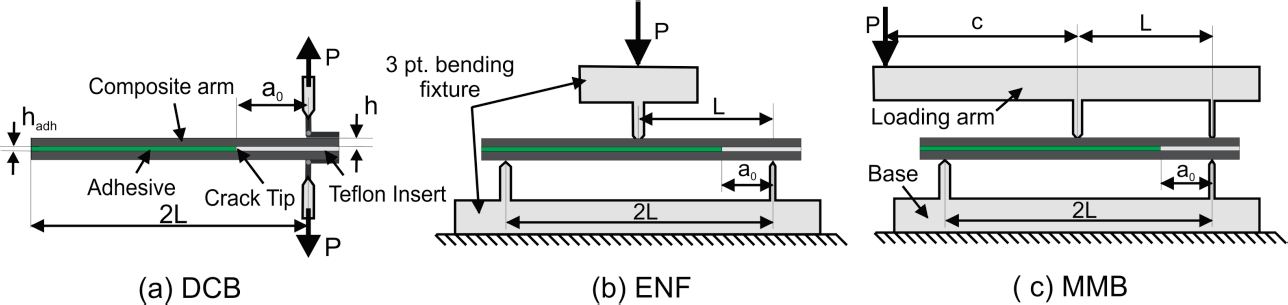
)

In [3]:
# Turon A, Camanho P P, Costa J, et al. Accurate simulation of delamination growth under mixed-mode loading using cohesive elements: definition of interlaminar strengths and elastic stiffness[J]. Composite structures, 2010, 92(8): 1857-1864.
# Li X, Chen J. An extended cohesive damage model for simulating multicrack propagation in fibre composites[J]. Composite Structures, 2016, 143: 1-8.

class DCBSpecimen:
    def __init__(self,b,h,a0):
        """
        a0: 初始裂纹长度 mm
        b : 宽度 mm
        h : 厚度一半 mm
        """
        self.a0=a0
        self.h=h
        self.b=b
    def load_disp(self,mat,G,a1=None,correct=True,N=101,growth=False):
        """
        E11: 材料轴向模量  MPa
        G  : I型断裂韧性  N/mm,KJ/m^2
        a1 : 裂纹扩展最终长度
        """
        a0,h,b=self.a0,self.h,self.b
        
        if a1 is None:
            a1=self.a0+50
        
        E11,E22,G12,G13,nu12=mat.E11,mat.E22,mat.G12,mat.G13,mat.nu12
        chi=0 if not correct else (E11/(11*G13)*(3-2*((1.18*(E11/E22)**0.5/G13)/(1+1.18*(E11/E22)**0.5/G13))**2))**0.5
        
        # A simple method for determining the mode I interlaminar fracture toughness of composite without measuring the growing crack length
        S=mat.planeStrainCompliance()
        E11,E22,G12,nu12=1/S[0,0],1/S[1,1],1/S[2,2],-S[0,1]/S[0,0]                
        rho=(E11*E22)**0.5/(2*G12)-(E22/E11)**0.5*nu12
        beta=(0.677+0.146*(rho-1)-0.0178*(rho-1)**2+0.00242*(rho-1)**3)/(E22/E11)**(0.25)
        print(rho,beta,chi)
        al=np.linspace(a0,a1,N)+beta*h
        
        I=b*h**3/12.0
        Fl=(G*b*I*E11)**0.5/al
        ul=(Fl*al**3)*(2/(3*I*E11))
        ul=np.concatenate(([0],ul))
        Fl=np.concatenate(([0],Fl))
        al=np.concatenate(([a0,],al-beta*h))
        
        fig=plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(ul,Fl)
        ax1.set_xlabel('$\delta$/mm')
        ax1.set_ylabel('P/N')
        if growth:
            ax2=ax1.twinx()
            ax2.plot(ul,al)
            ax2.set_ylabel('a/mm')
        return al,ul,Fl
    def __str__(self):
        return '<DCB B:%.2fmm 2h:%.2fmm a0:%.2fmm>'%(self.b,self.h*2,self.a0)
    
class ENFSpecimen:
    def __init__(self,L,b,h,a0,correct=True):
        """
        L : 跨距长度一半 mm
        a0: 初始裂纹长度 mm
        b : 宽度 mm
        h : 厚度一半 mm
        """
        self.a0=a0
        self.h=h
        self.b=b
        self.L=L
        self.correct=correct
    def load_disp(self,mat,GII,a1=None,N=101):
        a0,L,h,b=self.a0,self.L,self.h,self.b

        if a1 is None:
            a1=self.L
        
        E11,E22,G13=mat.E11,mat.E22,mat.G13
        chi=0.0 if not self.correct else (E11/(11*G13)*(3-2*((1.18*(E11/E22)**0.5/G13)/(1+1.18*(E11/E22)**0.5/G13))**2))**0.5
        al=np.linspace(a0,a1,N)+0.42*chi*h
        
        print(chi)
        
        Fl=((4./3)*(GII*b**2*h**3*E11)**0.5)/al
        ul=(Fl*(3*al**3+2*L**3))/(8*b*h**3*E11)
        ul=np.concatenate(([0],ul))
        Fl=np.concatenate(([0],Fl))        
        plt.plot(ul,Fl)
        return ul,Fl
    def __str__(self):
        return '<ENF 2L:%.2fmm B:%.2fmm 2h:%.2fmm a0:%.2fmm>'%(2*self.L,self.b,self.h*2,self.a0)

class MMBSpecimen:
    def __init__(self,L,b,h,c,a0):
        """
        L : 跨距长度
        a0: 初始裂纹长度 mm
        b : 宽度 mm
        h : 厚度一半 mm
        c : 
        """
        self.a0=a0
        self.h=h
        self.b=b
        self.L=L
        self.c=c
    def load_disp(self,mat,Gc,a1=None,N=101):
        a0,L,h,b,c=self.a0,self.L,self.h,self.b,self.c

        E11,E22,G13=mat.E11,mat.E22,mat.G13      
        chi=(E11/(11*G13)*(3-2*((1.18*(E11/E22)**0.5/G13)/(1+1.18*(E11/E22)**0.5/G13))**2))**0.5        
        
        I=b*h**3/12.0
        al=np.linspace(a0,a1,N)
        Fl=((Gc*E11*I*64*b*L**2)/(4*(3*c-L)**2*(al+chi*h)**2+3*(c+L)**2*(al+0.42*chi*h)**2))**0.5
        ul=Fl*(4*(3*c-L)**2*(al+chi*h)**3+(c+L)**2*(3*(al+0.42*chi*h)**3+2*L**3))/(96*L**2*I*E11)
        ul=np.concatenate(([0],ul))
        Fl=np.concatenate(([0],Fl))
        plt.plot(ul,Fl)
        return ul,Fl
    def __str__(self):
        return '<MMB 2L:%.2fmm B:%.2fmm 2h:%.2fmm a0:%.2fmm c:%.2fmm>'%(2*self.L,self.b,self.h*2,self.a0,self.c)
        

In [4]:
print(DCBSpecimen(20,1.55,35,),ENFSpecimen(50,20,1.55,35),MMBSpecimen(51,25.4,1.56,63,39.3),sep='\n')

<DCB B:20.00mm 2h:3.10mm a0:35.00mm>
<ENF 2L:100.00mm B:20.00mm 2h:3.10mm a0:35.00mm>
<MMB 2L:102.00mm B:25.40mm 2h:3.12mm a0:39.30mm c:63.00mm>


3.7647490292467447 1.707126673530597 2.496750655961009
2.496750655961009


(array([ 0.        ,  6.0534624 ,  6.06017084, ..., 17.5204567 ,
        17.536348  , 17.55224771]),
 array([  0.        , 118.87063321, 118.75679111, ...,  60.74601876,
         60.71626825,  60.68654686]))

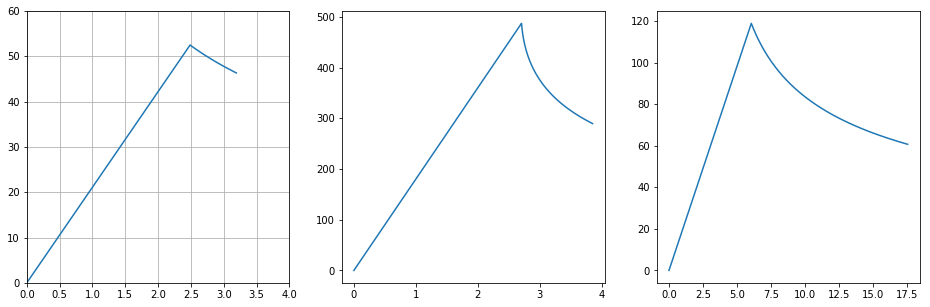

In [5]:
# Turon A, Camanho P P, Costa J, et al. Accurate simulation of delamination growth under mixed-mode loading using cohesive elements: definition of interlaminar strengths and elastic stiffness[J]. Composite structures, 2010, 92(8): 1857-1864.

mat=AnisoMaterial([120e3,10.5e3,10.5e3,0.5,0.3,0.3,3.48e3,5.25e3,5.25e3,])
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.grid()
plt.axis((0,4.0,0,60))
DCBSpecimen(20,1.55,35,).load_disp(mat,0.26,40)

plt.subplot(1,3,2)
ENFSpecimen(50,20,1.55,35,correct=True).load_disp(mat,1.002,60)

plt.subplot(1,3,3)
MMBSpecimen(51,25.4,1.56,63,39.3).load_disp(mat,0.719,80)

2.993876889366464 1.7143942355161994 2.4308616655515944
2.4666364255502677


(array([0.        , 2.38256511, 2.38330087, ..., 4.80338012, 4.8071678 ,
        4.81095787]),
 array([  0.        , 479.01754365, 478.54153002, ..., 240.38279784,
        240.26286493, 240.14305164]))

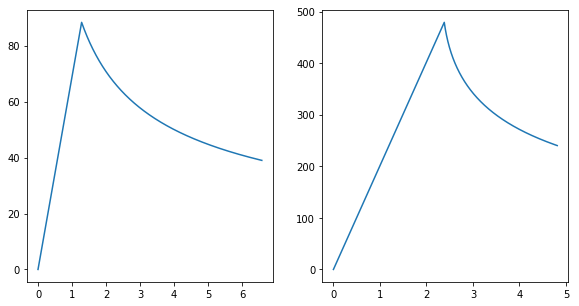

In [6]:
# Li X, Chen J. An extended cohesive damage model for simulating multicrack propagation in fibre composites[J]. Composite Structures, 2016, 143: 1-8.

mat1=AnisoMaterial([130e3,8e3,8e3,0.5,0.27,0.27,6e3,6e3,6e3,])
mat2=AnisoMaterial([122.7e3,10.1e3,10.1e3,0.5,0.25,0.25,5.5e3,5.5e3,5.5e3,])
mat3=AnisoMaterial([130e3,8e3,8e3,0.5,0.27,0.27,6e3,6e3,6e3,])
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
DCBSpecimen(24,1.55,25,).load_disp(mat1,0.256,60)

plt.subplot(1,3,2)
ENFSpecimen(51,25.4,1.56,39.3).load_disp(mat2,0.719,80)



2.9190257111053146


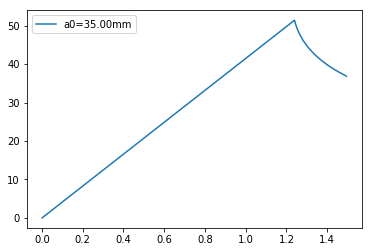

In [7]:
## T300-7901

T300_7901=AnisoMaterial((137.78e3,8.91e3,8.91e3,0.48,0.3,0.3,3.01e3,4.41e3,4.41e3))
lgds=[]
for a0 in range(35,36):
    enf=ENFSpecimen(50,1.0,2.5,a0)
    u,F=enf.load_disp(T300_7901,1.0,50)
    lgds.append('a0=%.2fmm'%a0)
plt.legend(lgds)
#u,F=enf.load_disp(T300_7901,0.3,80)
#dcb=DCBSpecimen(25,1.5,50)
#dcb.load_disp(T300_7901,0.3,100)

In [16]:
L,b,h,a=50,1,2.5,35
C1=(3*(a+0.42*2.9190257111053146*2.5)**3+2*L**3)/(137.78e3*8*b*h**3)
C2=(3*a**3+2*L**3)/(137.78e3*8*b*h**3)+0.3*L/(T300_7901.G13*b*h)
1/C1,1/C2

(41.45386276980889, 42.83596894371842)

2.9190257111053146


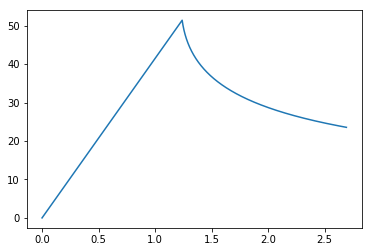

In [8]:
T300_7901=AnisoMaterial((137.78e3,8.91e3,8.91e3,0.48,0.3,0.3,3.01e3,4.41e3,4.41e3))
enf=ENFSpecimen(50,1.0,2.5,35.0)
u,F=enf.load_disp(T300_7901,1.0,80)

4.412408443037351 1.9792904287196673 2.9190257111053146
4.412408443037351 1.9792904287196673 2.9190257111053146


Text(0.5, 1.0, 'XAS_913C DCB Crack Growth')

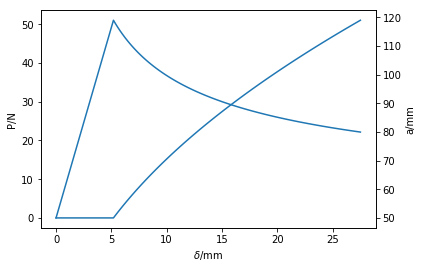

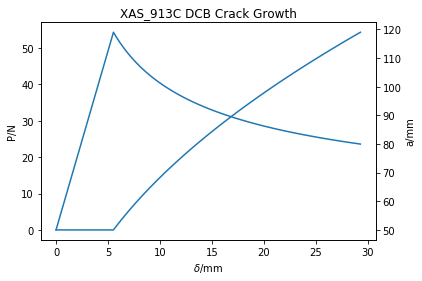

In [92]:

#4.Turon A, Davila C G, Camanho P P, et al. An engineering solution for mesh size effects in the simulation of delamination using cohesive zone models[J]. Engineering fracture mechanics, 2007, 74(10): 1665-1682.
T300_977_2=AnisoMaterial((150e3,11e3,11e3,0.45,0.25,0.25,3.7e3,6.0e3,6.0e3))

# Borg R, Nilsson L, Simonsson K. Simulating DCB, ENF and MMB experiments using shell elements and a cohesive zone model[J]. Composites Science and Technology, 2004, 64(2): 269-278.
HTA_6376C=AnisoMaterial((120e3,10.5e3,10.5e3,0.51,0.3,0.3,3.48e3,5.25e3,5.25e3))
b,h,a0,GI=20,1.55,35,0.259

# Mollón V, Bonhomme J, Elmarakbi A M, et al. Finite element modelling of mode I delamination specimens by means of implicit and explicit solvers[J]. Polymer Testing, 2012, 31(3): 404-410.
AS4_8552=AnisoMaterial((144e3,10.6e3,10.6e3,0.5,0.3,0.3,3.534e3,5.36e3,5.36e3))
b,h,a0,a1,GI=25,3,45,100,0.259


# Effect of stacking sequence on R-curve behavior of glass/epoxy DCB laminates with 0 ◦ //0 ◦ crack interface
EGlass_ML506=AnisoMaterial((33.5e3,10.23e3,10.23e3,0.5,0.27,0.27,3.41e3,4.26e3,4.26e3))
b,h,a0,a1,GI=25,2.1,35,95,0.55

# A numerical and experimental investigation of delamination behaviour in the DCB specimen
IM7_8552=AnisoMaterial(((160e3,10e3,10e3,0.52,0.31,0.31,3.2e3,4.8e3,4.8e3)))
b,h,a0,a1,GI=20,1.56,65,125,0.22

# A Modified DCB Specimen for Mode I Testing of Multidirectional Laminates
XAS_913C=AnisoMaterial((150e3,9.5e3,9.5e3,0.5,0.263,0.263,3.167e3,3.167e3,3.167e3))
b,h,a0,a1,GI=20,1.5,25,119,0.297

# Expr
T300_7901=AnisoMaterial((137.78e3,8.91e3,8.91e3,0.48,0.3,0.3,3.01e3,4.41e3,4.41e3))
b,h,a0,a1,GI=25,1.5,50,119,0.3

dcb1=DCBSpecimen(b,h,a0).load_disp(T300_7901,0.3,a1=a1,N=int(a1-a0)+1,growth=True)
dcb2=DCBSpecimen(b,h,a0).load_disp(T300_7901,0.34,a1=a1,N=int(a1-a0)+1,growth=True)
plt.title('XAS_913C DCB Crack Growth')
#plt.legend(['P','a'])
#plt.axis([0,35,0,40])

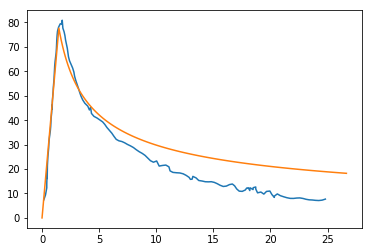

In [89]:
dp=np.array([0.041914305,7.407795011,0.189351147,9.418917583,0.300440428,12.32235641,0.301095339,14.10808044,0.335751046,19.71375488,0.33850713,16.11756574,0.356771871,21.47498039,0.373726789,23.26094698,0.398822616,25.02223313,0.436143447,26.7837012,0.465323371,28.56984971,0.48227829,30.3558163,0.511449118,32.11716309,0.560994955,33.87881308,0.610531697,35.61566134,0.643777527,37.37706877,0.660732445,39.16303536,0.681762366,40.94906259,0.723158199,42.7105913,0.769283946,46.25790468,0.772704037,44.47224129,0.794388868,48.04399255,0.827634698,49.80539998,0.852730524,51.56668613,0.873760444,53.35271336,0.90701537,55.13892251,0.936186198,56.9002693,0.953141117,58.68623589,0.970096035,60.47220248,0.995200958,62.25829035,1.028446788,64.01969778,1.073926719,65.80608885,1.119397555,67.56767819,1.144493381,69.32896434,1.157364201,71.09006857,1.178394122,72.8760958,1.20350814,74.6869854,1.240828972,76.44845346,1.331061156,78.03709779,1.482363792,79.47784138,1.584184263,79.33054704,1.654041438,80.91888817,1.709908986,77.69551319,1.819370085,76.15944366,1.892137975,74.57322493,1.944485376,72.86269438,2.021282789,71.15252768,2.098080201,69.44236097,2.15040941,67.68222698,2.202747716,65.94689471,2.291806517,64.33611682,2.425726724,62.82521285,2.56780603,61.33923189,2.673164839,59.72869656,2.737719054,57.96874449,2.838975574,56.28374334,2.956559389,54.67338993,3.074134108,53.03823479,3.183549727,51.37815665,3.301142638,49.79260496,3.447296946,48.30668463,3.634246752,46.94537932,3.862046633,45.85749936,3.890535262,45.75871695,4.032587281,44.19833082,4.138928456,45.26638153,4.215434797,42.7625597,4.430973289,41.57529093,4.703743726,40.88490557,4.96015958,40.04546731,5.188095901,39.32961319,5.379238957,38.29079091,5.566225147,37.02869249,5.777688637,35.84136308,5.997311226,34.67895667,6.192420133,33.34257436,6.383508613,32.15494175,6.615565416,31.56315688,6.876256383,31.26941717,7.120565479,30.75221938,7.36482,30.08621127,7.629476817,29.49491152,7.890022249,28.80434424,8.138269907,27.91518126,8.394694857,27.10054472,8.659315291,26.41003808,8.907590237,25.59528027,9.139474216,24.53226267,9.379490006,23.4197629,9.640062726,22.80360079,9.921419774,23.3038194,10.14478081,21.22380989,10.43419691,21.47613255,10.72765162,21.62930896,10.99633796,20.91406124,11.09760357,19.25386182,11.34595129,18.63751778,11.65152185,18.49325544,11.95711061,18.39859654,12.24223339,18.05561722,12.50687202,17.41471402,12.76329697,16.60007749,12.87709685,15.78331856,13.02789921,15.85996741,13.09351765,17.00181689,13.37039038,16.38589733,13.60634936,15.32294037,13.89966763,15.10409094,14.18073361,14.81065443,14.44966554,14.76505321,14.71048385,14.81853761,14.96710891,14.54953898,15.21956801,14.03246248,15.48012254,13.36669692,15.75296575,12.87472534,16.02604545,13.02759855,16.30337297,13.65176513,16.55202995,13.87867967,16.74735716,13.1375387,16.93026835,11.87537965,17.1499819,10.96099046,17.41482064,10.86572517,17.68805497,11.44022766,17.802437,12.21077898,17.83092563,12.11199657,17.94104164,12.36165107,18.07916419,11.19803186,18.09588261,12.33915367,18.36455985,11.59910422,18.37299183,12.3680789,18.59722609,12.66903477,18.60098273,11.80103512,18.75934385,10.26569327,19.04878723,10.5924211,19.30927809,9.75304348,19.54195342,10.84777575,19.83540813,11.00095216,20.01011474,9.589861486,20.22565323,8.402592714,20.22991925,8.923489529,20.48697182,9.820171859,20.75565816,9.104924136,21.04074456,8.662737922,21.32584916,8.270155153,21.61099923,8.001580997,21.90031527,7.981084708,22.18154497,8.134079198,22.45866329,8.187806157,22.73568155,7.968714167,23.00450433,7.625492284,23.27337259,7.406279014,23.55044543,7.33599736,23.83564099,7.191431817,24.12086383,7.121271443,24.41024354,7.274387212,24.6956483,7.700261291,]).reshape((-1,2))
plt.plot(dp[:,0]+6.878542999/60.4938437,dp[:,1])
plt.plot(dcb[1],dcb[2])

In [87]:
    np.savetxt('dcb_XAS_913C.txt',np.c_[dcb],fmt="%.6f",delimiter='\t')

In [85]:
dcb[0],dcb[1]

(array([ 25.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
         35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
         46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
         57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
         68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
         79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
         90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
        112., 113., 114., 115., 116., 117., 118., 119.]),
 array([ 0.        ,  1.42962532,  1.53033385,  1.63446984,  1.74203329,
         1.8530242 ,  1.96744257,  2.0852884 ,  2.20656169,  2.33126245,
         2.45939066,  2.59094634,  2.72592947,  2.86434007,  3.00617813,
         3.15144365,  3.30013663,  3.45225707,  3.60780497,  3.76678033,
         3.92918316,  4.09501344,  4.26427119,  4.43695639

In [43]:
dcb[2][1]/dcb[1][1]

55.96116624931808

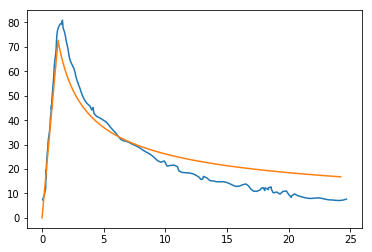